# Predpovedanie návštevnosti obchodu z historických dát

## Implementačná časť

 Najskôr dôležité importy.

In [50]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
import numpy_indexed as npi

Pomocná funkcia.

In [51]:
def printScores(scores, label):
    plt.scatter(scores[:, 0], scores[:, 1])
    plt.xlabel(label)
    plt.ylabel('score')
    plt.show()

Načítanie dát. Dáta sú agegované po hodinách a obsahujú postupne tieto atribúty: rok, mesiac, deň, hodina, deň v týždni a počet návštev(vstupov) za danú hodinu.
Dáta rozdelíme na trénovacie a testovacie v pomere 80:20.

In [52]:
data = np.loadtxt('pcnData.csv', delimiter=',')

X_train, X_test, y_train, y_test = train_test_split(data[:, :-1], data[:, -1], test_size=0.20, random_state=42)

Ako vyzerá priemerný deň?

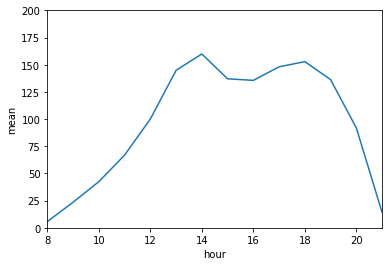

In [53]:
byHour = npi.group_by(data[:, 3]).mean(data[:, 5])

plt.plot(byHour[0], byHour[1], ls='-')
plt.xlabel('hour')
plt.ylabel('mean')
plt.axis([8, 21, 0, 200])
plt.show()

Priemerný týždeň.

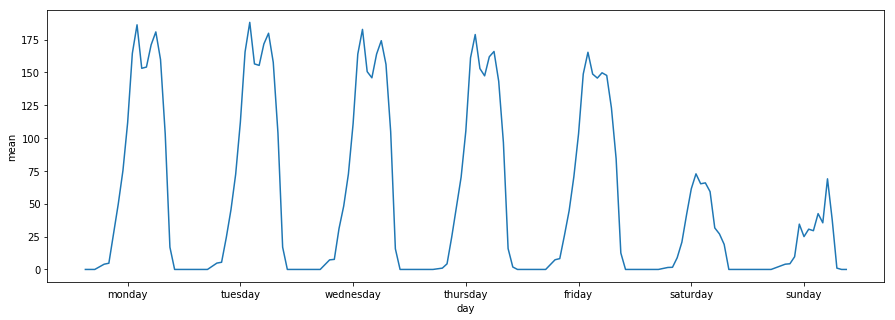

In [54]:
byHour = npi.group_by(((data[:,4]-1)*24)+data[:, 3]).mean(data[:, 5])

plt.figure(figsize=(15,5))
plt.plot(byHour[0], byHour[1], ls='-')
plt.xlabel('day')
plt.ylabel('mean')
x = np.array([i*24+12 for i in range(0, 7)])
my_xticks = ['monday','tuesday','wednesday','thursday','friday','saturday','sunday']
plt.xticks(x, my_xticks)
plt.show()

### Lineárna regresia

Trénovanie lineárnej regresie pre atribúty s polynomiálnym rozvojom do 10. stupňa. Pre každý natrénovaný model vypočítame scóre a zobrazíme v grafe.

processing degree 1 ...
processing degree 2 ...
processing degree 3 ...
processing degree 4 ...
processing degree 5 ...
processing degree 6 ...
processing degree 7 ...
processing degree 8 ...
processing degree 9 ...
processing degree 10 ...
done


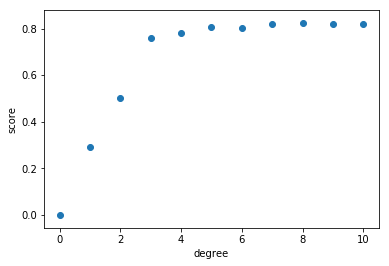

Best score 0.8221646898217925 for degree 8.


In [55]:
def testLinearRegression(data):
        
    degrees = 10
    scores = np.zeros((degrees+1, 2))

    for degree in range(1, degrees+1):

        print("processing degree {} ...".format(degree))
        polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)

        linear_regression = LinearRegression()
        pipeline = Pipeline([("polynomial_features", polynomial_features),
                             ("linear_regression", linear_regression)])

        pipeline.fit(X_train, y_train)
        score = pipeline.score(X_test, y_test)
        
        scores[degree] = [degree, score]
    
    print("done")
        
    printScores(scores, 'degree')
    bestDegree = np.argmax(scores[:, 1])
    print("Best score {} for degree {}.".format(scores[bestDegree][1], bestDegree))
    
testLinearRegression(data)

Skúske najlepší model otestovať cross validáciou.

In [56]:
bestDegree = 8

polynomial_features = PolynomialFeatures(degree=bestDegree, include_bias=False)

linear_regression = LinearRegression()
linreg = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
crossValScore = cross_val_score(linreg, data[:, :-1], data[:, -1], cv=cv).mean()

print("Cross validation score is {}".format(crossValScore))

Cross validation score is 0.8310495729503259


### Nádodné lesy

Teraz natrénujeme RandomForestRegressor spočtom stromov 20 a maximálnou hĺbkou po 30. Pre každý model opäť spočítame skóre a zovrazíme v grafe.

processing depth 1 ...
processing depth 2 ...
processing depth 3 ...
processing depth 4 ...
processing depth 5 ...
processing depth 6 ...
processing depth 7 ...
processing depth 8 ...
processing depth 9 ...
processing depth 10 ...
processing depth 11 ...
processing depth 12 ...
processing depth 13 ...
processing depth 14 ...
processing depth 15 ...
processing depth 16 ...
processing depth 17 ...
processing depth 18 ...
processing depth 19 ...
processing depth 20 ...
processing depth 21 ...
processing depth 22 ...
processing depth 23 ...
processing depth 24 ...
processing depth 25 ...
processing depth 26 ...
processing depth 27 ...
processing depth 28 ...
processing depth 29 ...
processing depth 30 ...
done


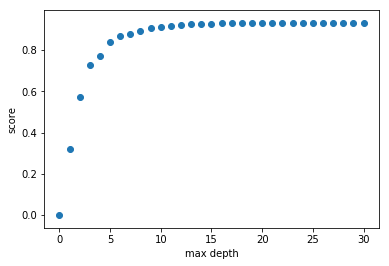

Best score 0.9309858615869754 for max depth 16.


In [57]:
def testRandomForestRegression(data):
        
    maxDepth = 30
    scores = np.zeros((maxDepth+1, 2))
    for depth in range(1, maxDepth+1):

        print("processing depth {} ...".format(depth))
        forest = RandomForestRegressor(n_estimators = 20, max_depth=depth, random_state=0)

        forest.fit(X_train, y_train)
        scores[depth] = [depth, forest.score(X_test, y_test)]

    print("done")
        
    printScores(scores, "max depth")

    bestDepth = np.argmax(scores[:, 1])
    print("Best score {} for max depth {}.".format(scores[bestDepth][1], bestDepth))
    
testRandomForestRegression(data)

Z grafu vidíme, že približne od maximálnej hĺbky 10 je skóre skoro rovnaké.

Otestujme cross validáciou najlepší model

In [58]:
bestDepth = 16

forest = RandomForestRegressor(n_estimators = 20, max_depth=bestDepth, random_state=0)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
crossValScore = cross_val_score(forest, data[:, :-1], data[:, -1], cv=cv).mean()

print("Cross validation score is {}".format(crossValScore))

Cross validation score is 0.9345194606436875


Nakoniec sa pozrime ako dokážu naše modely predpovedať priemerný týždeň.

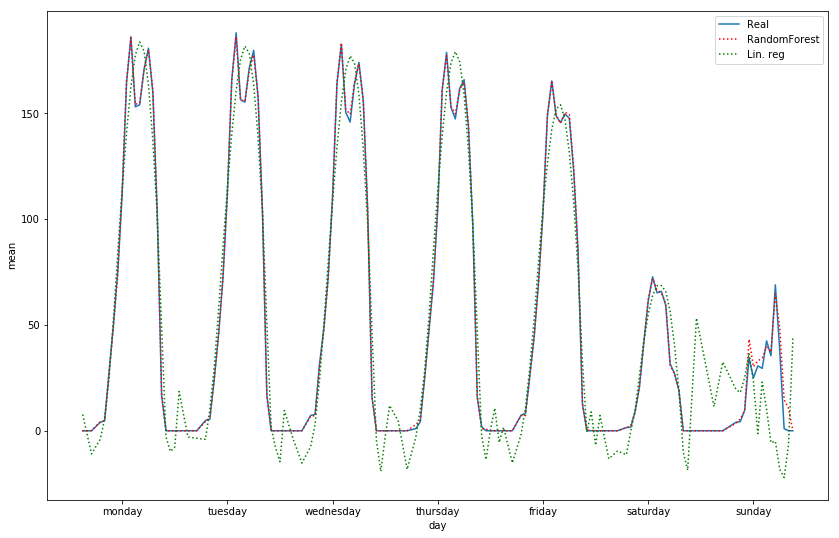

In [59]:
byHour = npi.group_by(((data[:,4]-1)*24)+data[:, 3]).mean(data[:, 5])

# predict with random forest
forest = RandomForestRegressor(n_estimators = 20, max_depth=16, random_state=0)
forest.fit(data[:, :-1], data[:, -1])
predicted = forest.predict(data[:, :-1])
byHourPredForest = npi.group_by(((data[:,4]-1)*24)+data[:, 3]).mean(predicted)

# predict with lin. regression
polynomial_features = PolynomialFeatures(degree=8, include_bias=False)
linear_regression = LinearRegression()
linreg = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
linreg.fit(data[:, :-1], data[:, -1])
predicted = linreg.predict(data[:, :-1])
byHourPredReg = npi.group_by(((data[:,4]-1)*24)+data[:, 3]).mean(predicted)

plt.figure(figsize=(14,9))
real, = plt.plot(byHour[0], byHour[1], ls='-', label = "Real")
forest, = plt.plot(byHourPredForest[0], byHourPredForest[1], ls=':', color='red', label = "RandomForest")
linreg, = plt.plot(byHourPredReg[0], byHourPredReg[1], ls=':', color='green', label = "Lin. reg")
plt.legend(handles=[real, forest, linreg])
plt.xlabel('day')
plt.ylabel('mean')
x = np.array([i*24+12 for i in range(0, 7)])
my_xticks = ['monday','tuesday','wednesday','thursday','friday','saturday','sunday']
plt.xticks(x, my_xticks)
plt.show()